In [1]:
import numpy as np
import matplotlib.pyplot as plt
import linelist as ls
from scipy.optimize import curve_fit
from scipy.special import wofz
# from lmfit.models import VoigtModel
import astropy.units as u
from scipy.signal import savgol_filter

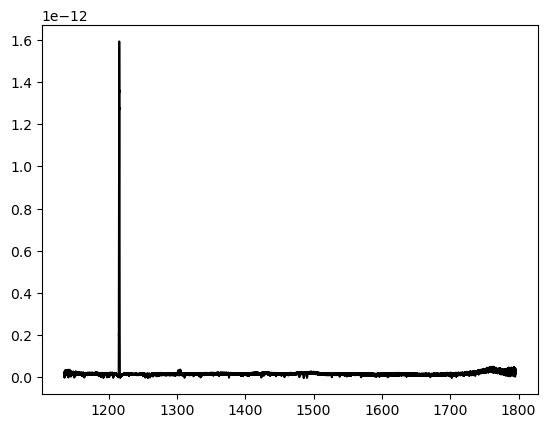

In [2]:
%matplotlib inline
wavelength, flux, error, continuum = np.loadtxt('data/spec_HE0153-4520_LA.dat', usecols=[0,1,2,3]).transpose()
normalised_flux = flux/continuum
c = 299792.458 # km/s
plt.plot(wavelength, flux, 'k-')
z = 0.45#5730/ls.find_line('Lya')[0]-1
# print('Redshift: ', z)
plt.show()

## Normalised flux

(1135.29231, 1795.20538)

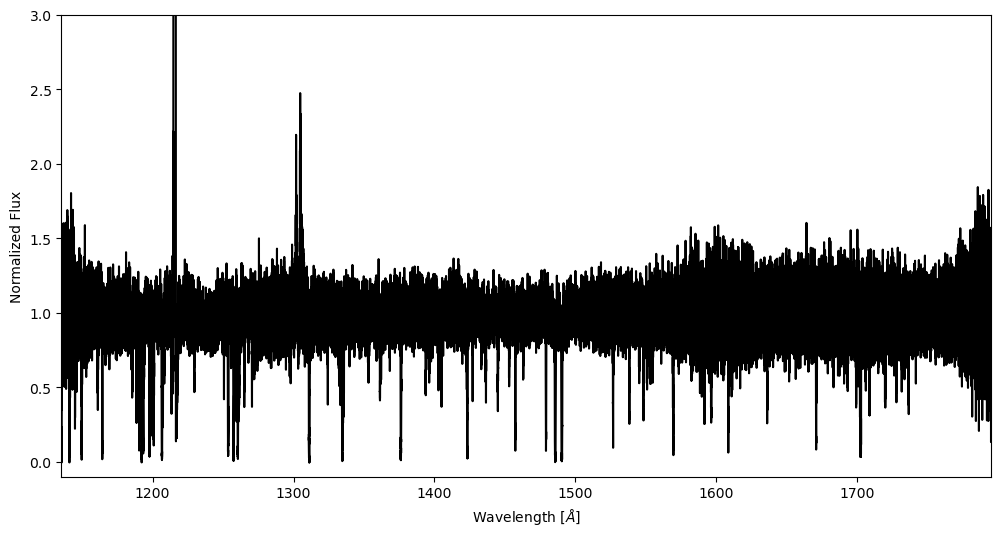

In [3]:
plt.figure(figsize=(12,6))
plt.plot(wavelength, normalised_flux, 'k-')
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Normalized Flux')
plt.ylim(-0.1, 3)
plt.xlim(wavelength[0], wavelength[-1])

In [4]:
# %matplotlib widget
def zoom(a, b=None, w=200):
    if b == None:
        b = a+w/2
        a -= w/2
    plt.plot(wavelength, normalised_flux, 'k-')
    plt.xlabel('Wavelength [$\AA$]')
    plt.ylabel('Normalized Flux')
    plt.xlim(a, b)

def velocity_space(wl, w=200):
    delta_wl = wavelength-wl
    v = c*delta_wl/wavelength
    plt.plot(v, normalised_flux, 'k-')
    plt.xlabel('Velocity [km s$^{-1}$]')
    plt.ylabel('Normalized Flux')
    plt.xlim(-w, w)
    return v

In [5]:
from scipy.ndimage import gaussian_filter1d

def voight(x, x0, sigma, gamma):
    return 1-np.real(wofz((x - x0 + 1j*gamma)/sigma/np.sqrt(2)))

def broaden(x, x0, sigma, gamma, kernel):
    return gaussian_filter1d(voight(x, x0, sigma, gamma), kernel)

In [6]:
def fit_profile(wl, w=150, p0=None):
    v = velocity_space(wl)
    roi = np.where((v < w) & (v > -w))
    xs, ys = v[roi], savgol_filter(normalised_flux, 25, 5)[roi]
    
    params, cov = curve_fit(broaden, xs, ys, p0=[0, 15, 1, np.mean(error_array[roi])], sigma=error_array[roi], absolute_sigma=True)
    fit_x = np.linspace(xs[0], xs[-1], 200)
    print(params)
    fit_y = broaden(fit_x, *params)

    # redo delta lambda
    v = velocity_space(params[1])
    plt.plot(fit_x, fit_y, 'r-')
    plt.plot(v, normalised_flux, 'k-', alpha=0.8)
    # plt.ylim(np.min(ys)-0.1, 1.05)
    plt.xlim(-w, w)
    # plt.show()

    errs = np.sqrt(np.diag(cov))
    b, berr = np.sqrt(2)*params[1], np.sqrt(2)*errs[1]
    return (b, berr), params[2]

error_array = error/continuum

In [7]:
def gaussian(x, A, mu, sigma): return 1-A*np.exp(-(x-mu)**2/(2*sigma**2))

def fit_gaussian(xs, ys, p0=None):
    popt, pcov = curve_fit(f=gaussian, xdata=xs, ydata=ys, p0=p0, maxfev=5000)
    xFit = np.arange(min(xs)-20,max(xs)+20, 2e-4)
    return xFit, gaussian(xFit, *popt), popt

## SiIV

+-----------+--------------+-------+----------+
| Line      |   Wavelength |     f |    Gamma |
|-----------+--------------+-------+----------|
| SiIV_1402 |      1402.77 | 0.254 | 8.62e+08 |
| SiIV_1393 |      1393.76 | 0.513 | 8.8e+08  |
| SiIV      |      1393.76 | 0.513 | 8.8e+08  |
+-----------+--------------+-------+----------+


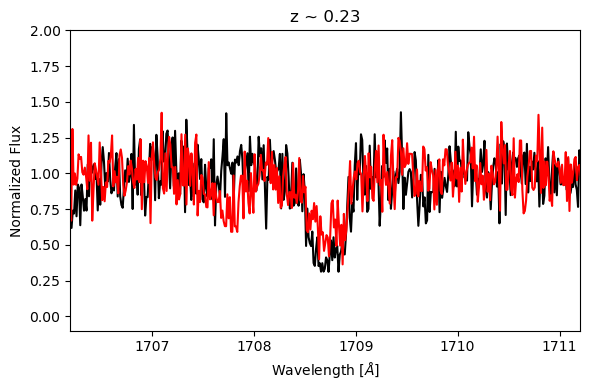

1708.7636976000001

In [29]:
wls = ls.find_line('SiIV')
a,b = 1393.76, 1402.77

%matplotlib inline
plt.figure(figsize=(6,4))

zoom(1708.7, w=5)
plt.plot(wavelength*(a/b), normalised_flux, 'r')
plt.title(f'z ~ {1708.7/a-1:.2f}')

plt.ylim(-0.1, 2)
plt.tight_layout()
plt.show()
a*(zabs+1)

[ 0.25062777 21.41761982 11.37576718  1.00729073]
b: 30 ± 2, gamma: 11.38


(0.0, 1.5)

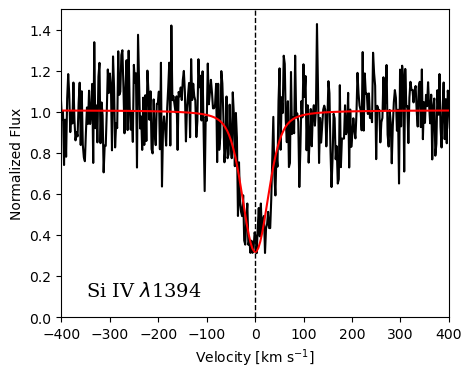

In [56]:
plt.figure(figsize=(5,4))
wl = 1394*(1+zabs)
window = 2
# zoom(1394, w=window)

roi = np.where((abs(wavelength-wl) < window))
xs = wavelength[roi]
ys = normalised_flux[roi]
xfit, yfit, params = fit_gaussian(xs, ys, p0=[np.min(ys), wl, 2])
# plt.plot(xfit, yfit)
# plt.plot(xs, ys)

wl = params[1]
# velocity_space(wl, w=300)

b, gamma = fit_profile(wl, w=400)
print(f'b: {b[0]:.0f} ± {b[1]:.0f}, gamma: {gamma:.2f}')

plt.axvline(0, linestyle='--', linewidth=1, color='k')
plt.text(-350, 0.1, f'Si IV $\lambda${wl/(1+zabs):.0f}',fontsize=14, fontdict={'family': 'serif'})

plt.ylim(0, 1.5)

## O VI

+----------+--------------+--------+-----------+
| Line     |   Wavelength |      f |     Gamma |
|----------+--------------+--------+-----------|
| OVI_1031 |      1031.93 | 0.1325 | 4.149e+08 |
| OVI      |      1031.93 | 0.1325 | 4.149e+08 |
| OVI_1037 |      1037.62 | 0.0658 | 4.076e+08 |
+----------+--------------+--------+-----------+


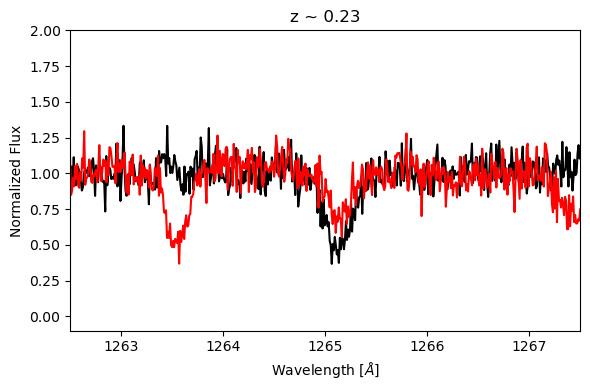

In [35]:
wls = ls.find_line('OVI')
a,b = 1031.93, 1037.62

%matplotlib inline
plt.figure(figsize=(6,4))

zoom(1265, w=5)
plt.plot(wavelength*(a/b), normalised_flux, 'r')
plt.title(f'z ~ {1265/a-1:.2f}')

plt.ylim(-0.1, 2)
plt.tight_layout()
plt.show()
# a*(zabs+1)

[-0.47642165 20.90578017 18.68222476  1.02192224]
b: 30 ± 1, gamma: 18.68


(0.0, 1.5)

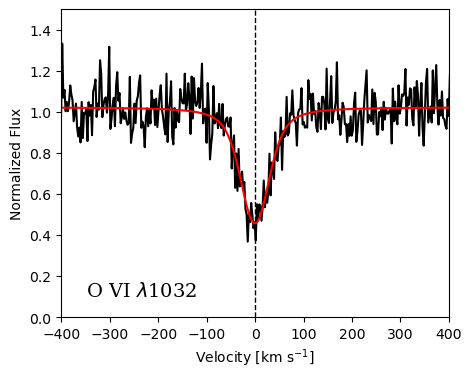

In [ ]:
plt.figure(figsize=(5,4))
wl = 1265
window = 2
# zoom(1394, w=window)

roi = np.where((abs(wavelength-wl) < window))
xs = wavelength[roi]
ys = normalised_flux[roi]
xfit, yfit, params = fit_gaussian(xs, ys, p0=[np.min(ys), wl, 2])
# plt.plot(xfit, yfit)
# plt.plot(xs, ys)

wl = params[1]
# velocity_space(wl, w=300)

b, gamma = fit_profile(wl, w=400)
print(f'b: {b[0]:.0f} ± {b[1]:.0f}, gamma: {gamma:.2f}')

plt.axvline(0, linestyle='--', linewidth=1, color='k')
plt.text(-350, 0.1, f'O VI $\lambda${wl/(1+zabs):.0f}',fontsize=14, fontdict={'family': 'serif'})

plt.ylim(0, 1.5)

## SiIII

+------------+--------------+------+----------+
| Line       |   Wavelength |    f |    Gamma |
|------------+--------------+------+----------|
| SiIII_1206 |       1206.5 | 1.63 | 2.48e+09 |
| SiIII      |       1206.5 | 1.63 | 2.48e+09 |
+------------+--------------+------+----------+


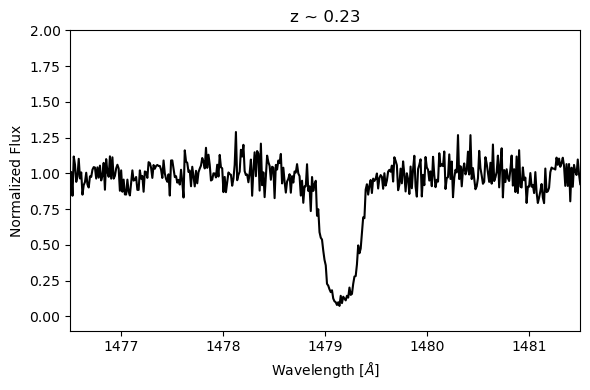

1479.181065

In [46]:
wls = ls.find_line('SiIII')
a = 1206.5

%matplotlib inline
plt.figure(figsize=(6,4))

zoom(1479, w=5)
# plt.plot(wavelength*(a/b), normalised_flux, 'r')
plt.title(f'z ~ {1480/a-1:.2f}')

plt.ylim(-0.1, 2)
plt.tight_layout()
plt.show()
a*(zabs+1)

[-0.07196774 31.3607708   2.08182004  1.0049037 ]
b: 44 ± 1, gamma: 2.08


(0.0, 1.5)

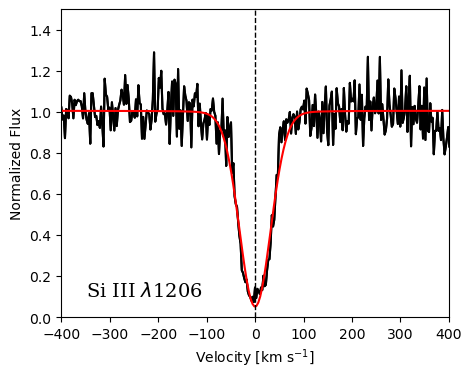

In [59]:
plt.figure(figsize=(5,4))
wl = 1479.5
window = 1.5
# zoom(wl, w=window)

roi = np.where((abs(wavelength-wl) < window))
xs = wavelength[roi]
ys = normalised_flux[roi]
xfit, yfit, params = fit_gaussian(xs, ys, p0=[np.min(ys), wl, 2])
# plt.plot(xfit, yfit)
# plt.plot(xs, ys)

wl = params[1]
velocity_space(wl, w=400)

b, gamma = fit_profile(wl, w=400)
print(f'b: {b[0]:.0f} ± {b[1]:.0f}, gamma: {gamma:.2f}')

plt.axvline(0, linestyle='--', linewidth=1, color='k')
plt.text(-350, 0.1, f'Si III $\lambda${wl/(1+zabs):.0f}',fontsize=14, fontdict={'family': 'serif'})

plt.ylim(0, 1.5)

## Carbon

+------------+--------------+------+----------+
| Line       |   Wavelength |    f |    Gamma |
|------------+--------------+------+----------|
| SiIII_1206 |       1206.5 | 1.63 | 2.48e+09 |
| SiIII      |       1206.5 | 1.63 | 2.48e+09 |
+------------+--------------+------+----------+


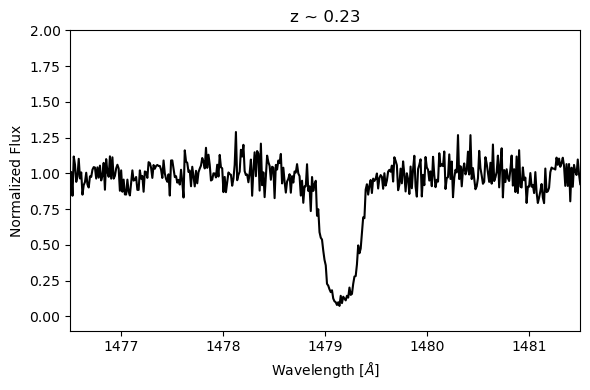

1479.181065

In [ ]:
wls = ls.find_line('SiIII')
a = 1206.5

%matplotlib inline
plt.figure(figsize=(6,4))

zoom(1479, w=5)
# plt.plot(wavelength*(a/b), normalised_flux, 'r')
plt.title(f'z ~ {1480/a-1:.2f}')

plt.ylim(-0.1, 2)
plt.tight_layout()
plt.show()
a*(zabs+1)

[-0.07196774 31.3607708   2.08182004  1.0049037 ]
b: 44 ± 1, gamma: 2.08


(0.0, 1.5)

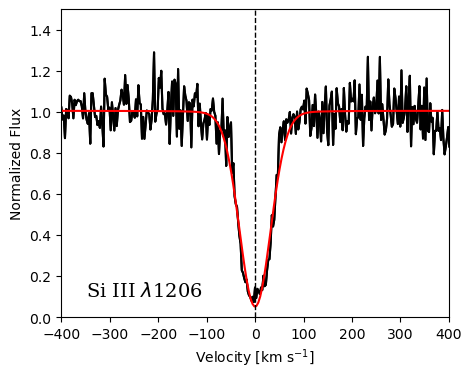

In [ ]:
plt.figure(figsize=(5,4))
wl = 1479.5
window = 1.5
# zoom(wl, w=window)

roi = np.where((abs(wavelength-wl) < window))
xs = wavelength[roi]
ys = normalised_flux[roi]
xfit, yfit, params = fit_gaussian(xs, ys, p0=[np.min(ys), wl, 2])
# plt.plot(xfit, yfit)
# plt.plot(xs, ys)

wl = params[1]
velocity_space(wl, w=400)

b, gamma = fit_profile(wl, w=400)
print(f'b: {b[0]:.0f} ± {b[1]:.0f}, gamma: {gamma:.2f}')

plt.axvline(0, linestyle='--', linewidth=1, color='k')
plt.text(-350, 0.1, f'Si III $\lambda${wl/(1+zabs):.0f}',fontsize=14, fontdict={'family': 'serif'})

plt.ylim(0, 1.5)